In [1]:
import os
import torch
import random
import numpy as np
import matplotlib.pyplot as plt

from types import SimpleNamespace
from skimage.segmentation import quickshift, slic, felzenszwalb
from how_to_use_utils import compute_relation_score_in_task, normalize_per_heatmap, plot_explanation, get_transform, get_correctly_classified_task

In [2]:
import sys
sys.path.append(os.getcwd())  # ensure project root is on PYTHONPATH

In [3]:
# Repository modules
from utils import init_device
from experiments import remove_superpixel
from relation_network import CNNEncoder, RelationNetwork

In [4]:
# Defining lighter version of settings.py
settings = {
    'dataset_type': 'rgb',
    'data_dir': 'data/CUB100',
    'seed': 50,
    'no_cuda': False,  # If True, disables GPU (CUDA)
    'no_mps': False,  # If True, disables macOS GPU (MPS) 
    'feature_dim': 64,
    'hidden_unit': 84,
    'model_prefix': 'CUB100',
    'class_num': 5,
    'train_batch_size': 1,
    'data_resize_shape': 84,
}

settings = SimpleNamespace(**settings)

In [5]:
# Relation score threshold for sample generation
RELATION_SCORE_THRESHOLD = 0.9

### RENEX Definition

In [6]:
def RENEX(query_set, support_set, feature_encoder, relation_network, segmentation_func,
          segmentation_params, replace_value, device, verbose=False):
    
    # Compute original relation scores (from unperturbed samples)
    original_relations = compute_relation_score_in_task(query_set, support_set, feature_encoder, relation_network, settings)

    # Generate heatmap explanations for all query-support pairs.
    # We will loop over all query indices and, for each, loop over all support samples.
    # We store heatmaps in a dictionary keyed by (query_idx, supp_idx).
    heatmaps = {}

    if settings.dataset_type == 'bw':
        replace_value = replace_value[0]

    for query_idx in range(settings.class_num):
        # Compute RENEX on correct classification tasks w/ rel score higher than given threshold
        query_scores = original_relations[query_idx, :]  
        predicted_support_idx = torch.argmax(query_scores).item()

        if predicted_support_idx == query_idx and query_scores[predicted_support_idx].item() >= RELATION_SCORE_THRESHOLD:
            print(f"Query sample {query_idx+1} correctly classified (highest score at support {predicted_support_idx+1}).")
        
            for supp_idx in range(5):
                # Convert the current support image to a NumPy array 
                support_image_np = support_set[supp_idx].permute(1, 2, 0).cpu().numpy()  # shape: [84,84,3] in [0,1]

                # Compute segments on the support image.
                if settings.dataset_type == 'bw':
                    # Applying Mask to Black drawn character on top of white background, so to only filter on those images
                    support_image_np_no_axis = support_image_np.squeeze(axis=2)
                    segmentation_params['mask'] = support_image_np_no_axis < 0.5 # Mask filters out white background, to only focus on black drawn characters.
                    segments = segmentation_func(support_image_np_no_axis, **segmentation_params)
                else:
                    segments = segmentation_func(support_image_np, **segmentation_params)
                
                unique_segments = np.unique(segments)
                
                if verbose:
                    print(f"Query {query_idx+1}, Support {supp_idx+1}: {len(unique_segments)} superpixels")
                
                # Get the original relation score for the pair (query_idx, supp_idx)
                original_score = original_relations[query_idx, supp_idx].item()
                print(f"Original Score for Query {query_idx+1} and Support {supp_idx+1}: {original_score:.3f}")
                
                # Create an empty heatmap (same spatial dimensions as the support image)
                heatmap = np.zeros(support_image_np.shape[:2], dtype=np.float32)
                
                # Loop over each superpixel in the support image.
                for segment_value in unique_segments:
                    # Perturb the support image for the current segment
                    perturbed_image = remove_superpixel(support_image_np, segments, segment_value, replace_value=replace_value)
                    # Convert the perturbed image back to a tensor of shape 
                    perturbed_image_tensor = torch.tensor(perturbed_image).permute(2, 0, 1).unsqueeze(0).float().to(device)

                    if verbose == True:
                        cmap = 'grey' if settings.dataset_type == 'bw' else None
                        plt.imshow(perturbed_image, cmap=cmap)
                        plt.show()
                    
                    # Rebuild the support set where only the current support sample (at supp_idx) is replaced by its perturbed version.
                    support_set_modified = []
                    for i in range(5):
                        if i == supp_idx:
                            support_set_modified.append(perturbed_image_tensor)
                        else:
                            support_set_modified.append(support_set[i].unsqueeze(0))
                    support_set_modified = torch.cat(support_set_modified, dim=0)  
                    
                    # Compute the relation score for the modified pair (query_idx, supp_idx)
                    relations_modified = compute_relation_score_in_task(query_set, support_set_modified, feature_encoder, relation_network, settings)
                    new_score = relations_modified[query_idx, supp_idx].item()
                    
                    # Compute the difference (delta) between original and new score.
                    delta = original_score - new_score
                    if verbose:
                        print(f" Query {query_idx+1}, Support {supp_idx+1} - Segment {segment_value}: New Score: {new_score:.3f}, Delta: {delta:.3f}")
                    
                    # Build/update the heatmap: distribute the delta over the pixels of this segment.
                    segment_mask = (segments == segment_value)
                    num_pixels = np.sum(segment_mask)
                    heatmap[segment_mask] = delta / num_pixels
                    
                # Store the heatmap for this (query, support) pair.
                heatmaps[(query_idx, supp_idx)] = heatmap
                            
    return heatmaps

### Seed and Device Initialization 

In [7]:
random.seed(settings.seed)
np.random.seed(settings.seed)
torch.manual_seed(settings.seed)
if not settings.no_cuda and torch.cuda.is_available():
    torch.cuda.manual_seed_all(settings.seed)

# Determine device.
device = init_device(settings.no_cuda, settings.no_mps)
print(f"Using device: {device}")

Using device: mps


In [8]:
REPLACING_COLORS = {
    'white_color': np.array([0, 0, 0], dtype=np.float32),
    'black_color': np.array([1, 1, 1], dtype=np.float32),
    'grey_color': np.array([128/255, 128/255, 128/255], dtype=np.float32),
    'violet_color': np.array([238/255, 130/255, 238/255], dtype=np.float32),
    'green_color': np.array([0, 1, 50/255], dtype=np.float32)
}

In [9]:
SEGMENTERS = [
    {'f': quickshift,   'p': {"kernel_size": 5, "max_dist": 10, "ratio": 0.5}},
    {'f': felzenszwalb, 'p': {"scale": 100, "sigma": 0.5, "min_size": 50}},
    {'f': slic,         'p': {"n_segments": 30, "compactness": 100, "start_label": 1}},
]

## CUB100 Example

In [10]:
# test directory
test_dir = f"./data/{settings.model_prefix}/test/"

# Determine in_channels for network initialization
in_channels = 1 if settings.dataset_type == 'bw' else 3
feature_encoder = CNNEncoder(in_channels=in_channels).to(device)
relation_network = RelationNetwork(settings.feature_dim, settings.hidden_unit, dataset_type=settings.dataset_type).to(device)

# Get image loading transformation
transform = get_transform(settings)

# Loads models and trained weights
model_feat_path = f"./models/{settings.model_prefix}_feature_encoder_{settings.class_num}way_{settings.train_batch_size}shot.pkl"
model_rel_path = f"./models/{settings.model_prefix}_relation_network_{settings.class_num}way_{settings.train_batch_size}shot.pkl"

if os.path.exists(model_feat_path):
    feature_encoder.load_state_dict(torch.load(model_feat_path, map_location=device))
    print("Loaded feature encoder.")
if os.path.exists(model_rel_path):
    relation_network.load_state_dict(torch.load(model_rel_path, map_location=device))
    print("Loaded relation network.")

# Select Replacing Colors
REPLACE_COLOR = REPLACING_COLORS['grey_color']

# Select Segmenter 
segmentation_func = SEGMENTERS[0]['f']
segmentation_params = SEGMENTERS[0]['p']

Loaded feature encoder.
Loaded relation network.


In [11]:
while True:
    query_set, support_set, original_relations = get_correctly_classified_task(settings, test_dir, transform, device, feature_encoder, relation_network)
    if query_set is not None:
        break

# Compute RENEX heatmaps.
heatmaps = RENEX(query_set,
                 support_set,
                 feature_encoder, 
                 relation_network, 
                 segmentation_func, 
                 segmentation_params, 
                 REPLACE_COLOR,
                 device,
                 False)

Query sample 2 correctly classified (highest score at support 2).
Original Score for Query 2 and Support 1: 0.396
Original Score for Query 2 and Support 2: 0.909
Original Score for Query 2 and Support 3: 0.015
Original Score for Query 2 and Support 4: 0.059
Original Score for Query 2 and Support 5: 0.028


Query sample 2 correctly classified (highest score at support 2).


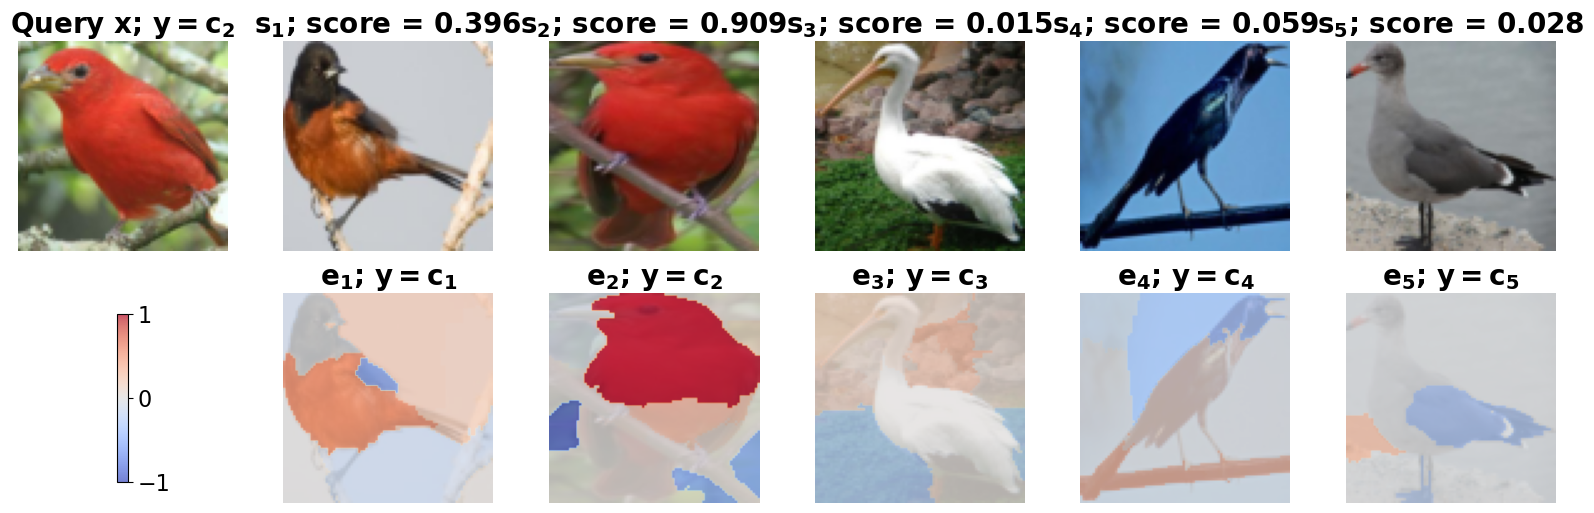

In [12]:
query_idx = 1
plot_explanation(query_idx, query_set, support_set, heatmaps, original_relations[query_idx, :].cpu().detach().numpy(), settings)

## Omniglot Example

In [13]:
settings.dataset_type = 'bw'
settings.model_prefix = 'Omniglot'
settings.data_dir = 'data/Omniglot' 

In [14]:
# test directory
test_dir = f"./data/{settings.model_prefix}/test/"

# Determine in_channels for network initialization
in_channels = 1 if settings.dataset_type == 'bw' else 3
feature_encoder = CNNEncoder(in_channels=in_channels).to(device)
relation_network = RelationNetwork(settings.feature_dim, settings.hidden_unit, dataset_type=settings.dataset_type).to(device)

# Get image loading transformation
transform = get_transform(settings)

# Loads models and trained weights
model_feat_path = f"./models/{settings.model_prefix}_feature_encoder_{settings.class_num}way_{settings.train_batch_size}shot.pkl"
model_rel_path = f"./models/{settings.model_prefix}_relation_network_{settings.class_num}way_{settings.train_batch_size}shot.pkl"

if os.path.exists(model_feat_path):
    feature_encoder.load_state_dict(torch.load(model_feat_path, map_location=device))
    print("Loaded feature encoder.")
if os.path.exists(model_rel_path):
    relation_network.load_state_dict(torch.load(model_rel_path, map_location=device))
    print("Loaded relation network.")

# Select Replacing Colors
REPLACE_COLOR = REPLACING_COLORS['black_color']

# Mask Slic
segmentation_func = slic
segmentation_params = {'n_segments':10, 'compactness':100, 'sigma':1, 'mask': None, 'channel_axis': None}

Loaded feature encoder.
Loaded relation network.


In [15]:
while True:
    query_set, support_set, original_relations = get_correctly_classified_task(settings, test_dir, transform, device, feature_encoder, relation_network)
    if query_set is not None:
        break

# Compute RENEX heatmaps.
heatmaps = RENEX(query_set,
                 support_set,
                 feature_encoder, 
                 relation_network, 
                 segmentation_func, 
                 segmentation_params, 
                 REPLACE_COLOR,
                 device,
                 False)

Query sample 1 correctly classified (highest score at support 1).
Original Score for Query 1 and Support 1: 0.972
Original Score for Query 1 and Support 2: 0.001
Original Score for Query 1 and Support 3: 0.016
Original Score for Query 1 and Support 4: 0.000
Original Score for Query 1 and Support 5: 0.434
Query sample 2 correctly classified (highest score at support 2).
Original Score for Query 2 and Support 1: 0.000
Original Score for Query 2 and Support 2: 0.972
Original Score for Query 2 and Support 3: 0.024
Original Score for Query 2 and Support 4: 0.180
Original Score for Query 2 and Support 5: 0.002
Query sample 4 correctly classified (highest score at support 4).
Original Score for Query 4 and Support 1: 0.001
Original Score for Query 4 and Support 2: 0.004
Original Score for Query 4 and Support 3: 0.016
Original Score for Query 4 and Support 4: 0.940
Original Score for Query 4 and Support 5: 0.005
Query sample 5 correctly classified (highest score at support 5).
Original Score f

Query sample 5 correctly classified (highest score at support 5).


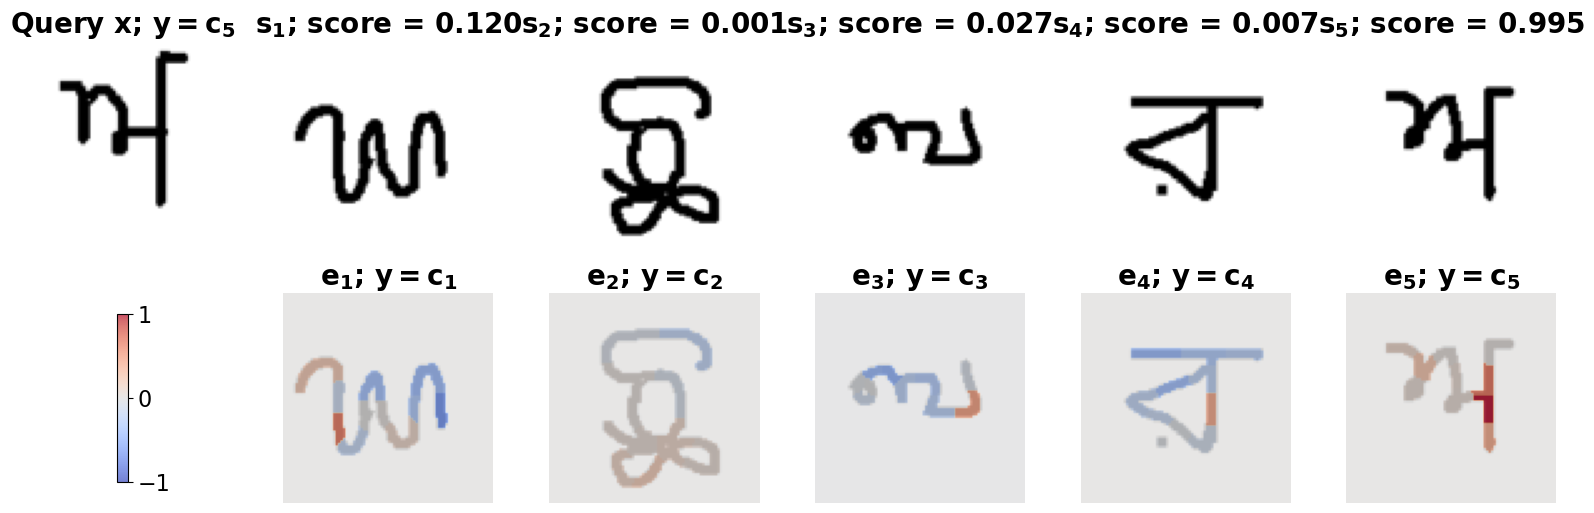

In [18]:
query_idx = 4
plot_explanation(query_idx, query_set, support_set, heatmaps, original_relations[query_idx, :].cpu().detach().numpy(), settings)